In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
data = pd.read_csv("datasets/fuses.csv")
x = data["time"]

In [3]:
w = .1
lam = .1
mu = 2
tau = 1
def f(x:np.ndarray, w=w, lam=lam, mu=mu, tau=tau):
    return w*stats.expon.pdf(x, scale=1/lam) + (1-w) * stats.lognorm.pdf(x, scale=np.exp(mu), s=tau)

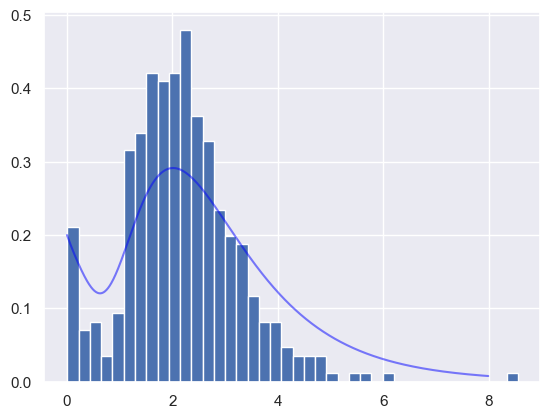

In [4]:
w = .2
lam = 1
mu = 1
tau = .5

plot_x = np.arange(0, 8, .01)
fig, ax = plt.subplots()
ax.hist(x, density=True, bins=int(len(x)/10))
ax.plot(plot_x, f(plot_x, w, lam, mu, tau), color="blue", alpha=0.5)

The following are equivalent

    > dlnorm(x, 2, 0.5)
    > stats.lognorm.pdf(scale=np.exp(2), s=0.5, x)

    > dgamma(x, 2, 1/2)
    > stats.gamma.pdf(a=2, scale=1/2, x)


In [5]:
# Prior Parameters
a_0 = 1
b_0 = 1
f_0 = 1
g_0 = 1

d_0 = 1
q_0 = 1

m_0 = 1
s_0 = 1

omega = 0.2
lam = 0.2
mu = np.mean(x)
tau = np.std(x)


omega_ = []
lam_ = []
mu_ = []
tau_ = []


for i in range(10000):
    p_C = np.zeros((len(x), 2))

    p_C[:,0] = np.log(omega) + stats.expon.logpdf(scale=1/lam, x=x)
    p_C[:,1] = np.log(1-omega) + stats.lognorm.logpdf(scale=np.exp(mu), s=tau, x=x)
    p_C_sum = np.sum(np.exp(p_C - np.max(p_C, axis=1).reshape(-1,1)), axis=1).reshape(-1,1)
    p_C = np.exp(p_C - np.max(p_C, axis=1).reshape(-1,1)) / p_C_sum

    # Sample Cluster assignments - 1 = cluster 2, 0 = cluster 1
    p = p_C[:,1]
    c = stats.bernoulli.rvs(p, size=len(x)) # yields 1 with probability p

    cluster_0 = np.where(c==0)[0]
    cluster_1 = np.where(c==1)[0]

    n_0 = len(cluster_0)
    n_1 = len(cluster_1)

    omega = stats.beta.rvs(a=a_0+n_0, b=b_0+n_1)

    # Cluster 1
    sum_0 = np.sum(x[cluster_0])
    
    f_star = f_0 + n_0
    g_star = g_0 + sum_0
    lam = stats.gamma.rvs(a=f_star, scale=1/g_star)

    # Cluster 2
    m_star = (np.sum(np.log(x[cluster_1])) / tau**2) + (m_0 / s_0**2)
    m_star = m_star / ((n_1 / tau**2) + (1/s_0**2))

    s_star = np.sqrt(1 / ((n_1 / tau**2) + (1/s_0**2)))

    mu = stats.norm.rvs(loc=m_star, scale=s_star)

    d_star = d_0 + n_1 / 2
    # d_star = d_0 + n_1 # He uses this as the solution

    q_star = q_0 + 0.5 * np.sum(np.power(np.log(x[cluster_1]) - mu, 2))

    tau = 1 / np.sqrt(stats.gamma.rvs(a=d_star, scale=1/q_star))

    omega_.append(omega)
    lam_.append(lam)
    mu_.append(mu)
    tau_.append(tau)

    w      = 0.1
    mu     = mean(log(x))
    tau    = sd(log(x))
    lambda = 20/mean(x)
    cc     = sample(1:2, n, TRUE, c(1/2, 1/2))


    # Full conditional for cc
    v = rep(0,2)
    for(i in 1:n){
        v[1]  = log(w) + dexp(x[i], lambda, log=TRUE)
        v[2]  = log(1-w) + dlnorm(x[i], mu, tau, log=TRUE)
        v     = exp(v - max(v))/sum(exp(v - max(v)))
        cc[i] = sample(1:2, 1, replace=TRUE, prob=v)
    }

    # Full conditional for w
    w = rbeta(1, 1+sum(cc==1), 1+n-sum(cc==1))

    lambda = rgamma(1, 1 + sum(cc==1), 1 + sum(x[cc==1]) )


    # Full conditional for mu
    mean.post = (sum(log(x[cc==2]))/tau^2 + 0)/(sum(cc==2)/tau^2 + 1)
    std.post = sqrt(1/(sum(cc==2)/tau^2 + 1))
    mu = rnorm(1, mean.post, std.post)

    # Full conditional for tau
    tau = sqrt(1/rgamma(1, 2 + sum(cc==2), 1 + 0.5*sum((log(x[cc==2]) - mu)^2)))

    
E{w}≈0.10, 
E{λ}≈2.29
E{μ}≈0.79
E{τ}≈0.38

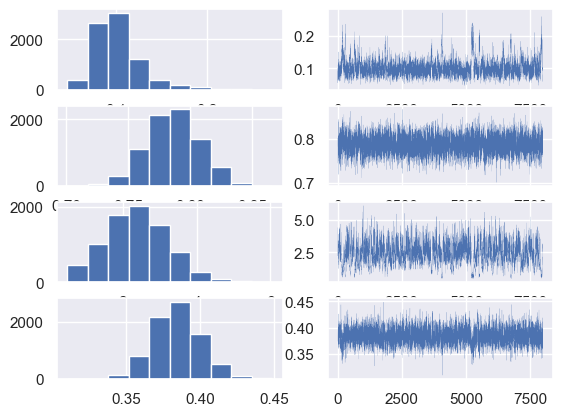

In [6]:
omega_ = np.array(omega_)[2000:]
mu_ = np.array(mu_)[2000:]
lam_ = np.array(lam_)[2000:]
tau_ = np.array(tau_)[2000:]

fig, ax = plt.subplots(4,2)
for i, value in enumerate([omega_, mu_, lam_, tau_]):
    ax[i, 0].hist(value)
    ax[i, 1].plot(value, linewidth=0.1)


In [7]:
w = np.mean(omega_)
lam = np.mean(lam_)
mu = np.mean(mu_)
tau = np.mean(tau_)

w, lam, mu, tau

(0.10169150443171894,
 2.391402152862468,
 0.7862619532573699,
 0.3840605351104901)

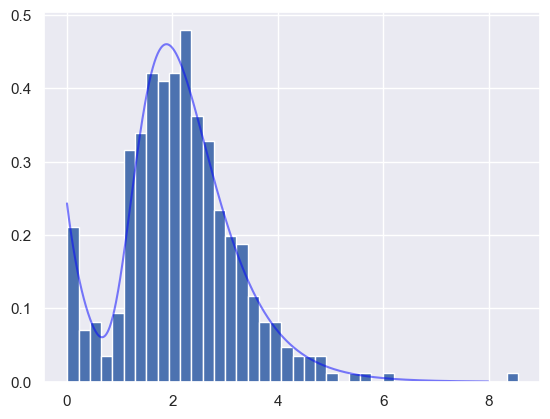

In [8]:
plot_x = np.arange(0, 8, 0.01)
fig, ax = plt.subplots()
ax.hist(x, density=True, bins=int(len(x)/10))
ax.plot(plot_x, f(plot_x, w, lam, mu ,tau), color="blue", alpha=0.5)